# MTE 544 Report

|Stephen Wang|Ajit Rakhra|Howard Dong|
|:-:|:-:|:-:|
|x2274wan|a3rakhra|h53dong|
|20821034|20832703|20847639|

Station 1, Robot 4 on Fri Oct 20 at 8:30 AM

In [1]:
%config InlineBackend.figure_formats = ["svg"]

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_data(name, parse=True):
    with open(name) as f:
        f.readline()
        data = f.read()
    if parse:
        return np.fromstring(data, sep=", ")
    else:
        return data

In [57]:
p_data = get_data("robot_pose.p.csv").reshape(-1, 4)
pid_data = get_data("robot_pose.pid.csv").reshape(-1, 4)

In [52]:
def plot_trajectory_to_point(x, y, goal, title, ax):
    ax.grid()
    ax.plot(x, y, marker="o", markersize=2, label="Robot Odometry")

    ax.plot([x[0], goal[0]], [y[0], goal[1]], label="Desired Trajectory")

    ax.plot(x[0], y[0], marker="o", markersize=10, label="Start")

    ax.plot(*goal, marker="o", markersize=10, label="Goal")
    
    ax.axis("square")
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()

In [ ]:
def plot_states_over_time(data, goal_point, theta_goal, title):
    x, y, theta, t = data.T
    t = (t - t[0]) * 1e-9
    duration = t[-1]
    x_slope = goal_point[0] - x[0]
    y_slope = goal_point[1] - y[0]

    fig, axes = plt.subplots(1, 3, figsize=(20,4))

    
    plot_trajectory_to_point(data[:,0], data[:,1], goal_point, title, axes[0])
    
    axes[1].plot(t, x, marker="o", markersize=2, label="x")
    axes[1].plot(t, x_slope/duration * t + x[0], label="desired x")
    
    axes[1].plot(t, y, marker="o", markersize=2, label="y")
    axes[1].plot(t, y_slope/duration * t + y[0], label="desired y")

    axes[1].grid()
    axes[1].legend()
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Position (m)")
    axes[1].set_title("Robot States Over Time")

    axes[2].plot(t, theta, marker="o", markersize=2, label=r"$\theta$")
    axes[2].plot([t[0], t[-1]], [theta_goal]*2, label=r"$\theta$ goal")
    
    axes[2].grid()
    axes[2].legend()
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Angle (rad)")
    axes[2].set_title("Robot Heading Over Time")

For point control, When comparing the trajectory and state variables of the robot motion under P and PID control, it can be seen that PID control provides a better trajectory. The x and y trajectories seem to be very similar, but one noticeable difference is between the theta values. Though both controllers result in steady-state error, PID control mitigates the overshoot of theta. 

Regarding our tuning process, we began by setting our K_i and K_d terms to 0 -- effectively turning our PID controller into a P controller. From here, we steadily increased our K_p in order to improve the response time (i.e. decrease rise time) for the system. We continued to increase K_p until we found the point where the system began to oscillate. We then set our K_p to about 0.6x as suggested by the Ziegler-Nichols method. At this point, we found we had fairly significant overshoot in the system still, and so we began to iteratively increase K_d until the overshoot dropped to what we felt was a reasonable amount in the simulation. The introduction of K_d however worsened our performance in terms of settling time, which was fixed by finally introducing our K_i term.  

A similar process was repeated for the angular velocities. Note that the I and D components of the linear motion did not have a significant affect on the linear motion as the motor very quickly saturated with P control alone. P control alone was forunately fairly effective at achieving the desired performance, meaning the I and D components did not need to be very large anyways.

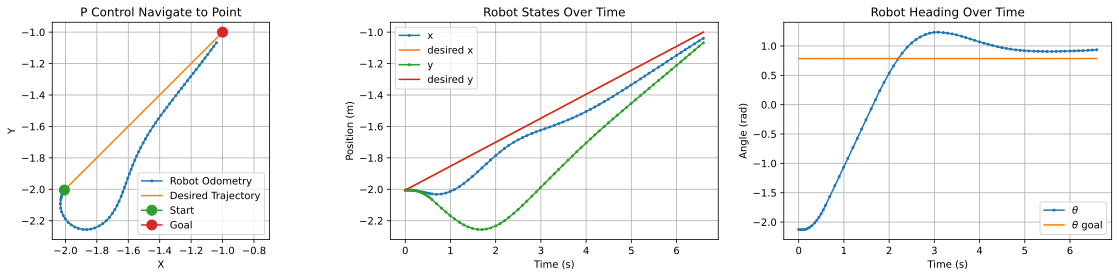

In [79]:
plot_states_over_time(p_data, (-1, -1), np.pi/4, "P Control Navigate to Point")

<i><p style="text-align: center">Figure 1: The three plots above show the robot driving to a point under the P controller. From left to right, the 2D trajectory, position states and theta states are plotted with the corresponding desired values. </i>
<div style="page-break-after: always;"></div>
<div><br/></div>

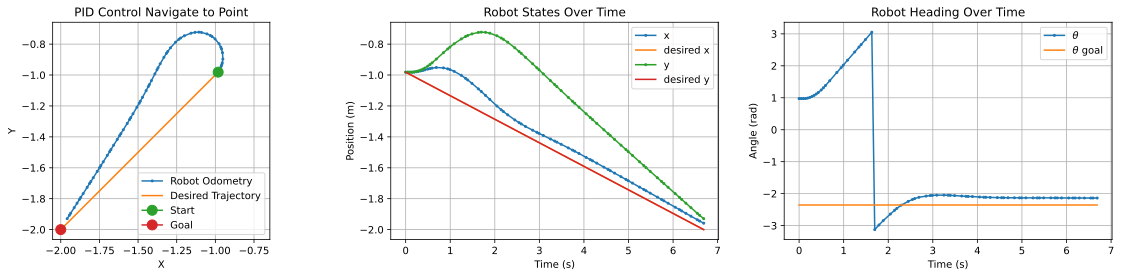

In [78]:
plot_states_over_time(pid_data, (-2, -2), -3*np.pi/4, "PID Control Navigate to Point")

<i><p style="text-align: center">Figure 2: The three plots above show the robot driving to a point under the PID controller. From left to right, the 2D trajectory, position states and theta states are plotted with the corresponding desired values.</i>

In [47]:
def plot_trajectory(x, y, ref_x, ref_y, title, ax):
    ax.plot(x, y, marker="o", markersize=2, label="robot odometry")
    ax.plot(ref_x, ref_y, marker="o", markersize=2, label="reference trajectory")
    ax.axis("scaled")
    ax.grid()
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

In [42]:
parabola_data = get_data("robot_pose.parabola.csv").reshape(-1, 4)
parabola_ref = np.load("parabola.npz")
parabola_ref_x = parabola_ref.get("arr_0")
parabola_ref_y = parabola_ref.get("arr_1")

In [43]:
sigmoid_data = get_data("robot_pose.sigmoid.csv").reshape(-1, 4)
sigmoid_ref = np.load("sigmoid.npz")


We also observed that trajectories densely sampled from the reference functions, at 100 points, the robot oscillated uncontrollably; changing the PID parameters did not reduce the oscillations.
We theorized that that there was a very significant amount of latency between the controller and the robot, ie the plant.
Thus, we ensured that there were no more than 21 points in the reference trajectory.
The resultant odometry plots, as shown below, are satisfactory, with the parameters tuned from point-to-point navigation.

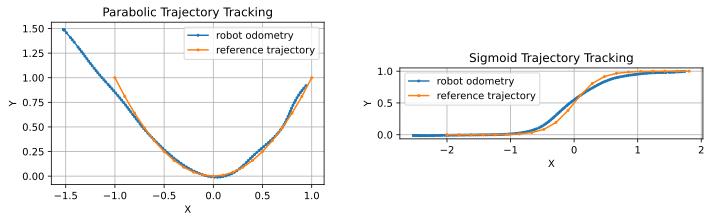

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))
plot_trajectory(parabola_data[:,0], parabola_data[:,1], parabola_ref_x, parabola_ref_y, "Parabolic Trajectory Tracking", axes[0])
plot_trajectory(sigmoid_data[:,0], sigmoid_data[:,1], sigmoid_ref.get("arr_0"), sigmoid_ref.get("arr_1"), "Sigmoid Trajectory Tracking", axes[1])

<i><p style="text-align: center">Figure 3: The two plots above show the robot trajectory under the PID controller. THe left plot shows the trajectory of parabolic tracking and the right plot shows the trajectory of sigmoid tracking. The blue line shows the robots trajectory, and the orange line shows the reference trajectory that the robot used for the motion.</i>
<div style="page-break-after: always;"></div>
<div><br/></div>

In [87]:
def plot_trajectory_error(x, y, func, title, ax):
    ax.grid()
    ax.plot(x, func(x) - y, marker="o", markersize=2)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

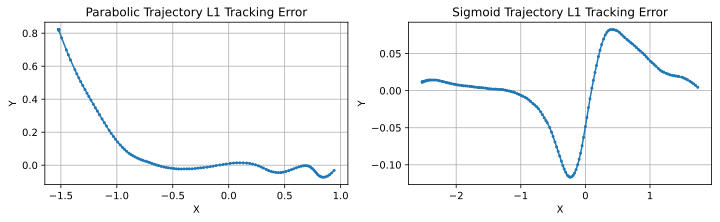

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))
plot_trajectory_error(parabola_data.T[0], parabola_data.T[1], lambda x : x**2, "Parabolic Trajectory L1 Tracking Error", axes[0])
plot_trajectory_error(sigmoid_data.T[0], sigmoid_data.T[1], lambda x : 1 / (np.exp(-5*x) + 1), "Sigmoid Trajectory L1 Tracking Error", axes[1])

<i><p style="text-align: center">Figure 4: The two plots above show the robot trajectory L1 error relative to the reference trajectory. From left plot shows the error of parabolic tracking and the right plot shows the error of sigmoid tracking.</i>

The sigmoid trajectory illustrates the limitation of using PID for steering control.
The reference signal is exclusively based on (up to, if at the end) the third next point in the trajectory, without considering the possible curvature that intermediate points would create.
This resulted in an odometry trajectory that conforms to the general shape of the function but it looks like $ \frac{1}{1+e^{-3x}} $ rather than $ \frac{1}{1+e^{-5x}} $.

Depending on the application, this may not be consequential. However, if the trajectory was planned to optimize a very specific objective, failing to follow the trajectory exactly would produce a suboptimal path.